In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# File system management
import os
import shutil
import time

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn metrics and model selection
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score, roc_auc_score, 
    accuracy_score, log_loss, matthews_corrcoef, confusion_matrix, classification_report, roc_curve
)
from sklearn.model_selection import (
    cross_validate, RepeatedKFold, RandomizedSearchCV, train_test_split
)

# sklearn feature selection and classification algorithms
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model evaluation
from sklearn.impute import KNNImputer
from scipy.stats import spearmanr, uniform, randint, loguniform

# MLflow for tracking experiments
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature
import joblib

# Enable experimental features
from sklearn.experimental import enable_hist_gradient_boosting  # HistGradientBoostingClassifier

from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE  # Ajout de SMOTE pour gérer les données déséquilibrées
from imblearn.pipeline import Pipeline as ImbPipeline  # Utilisation de la pipeline d'imblearn pour inclure SMOTE

from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import ast
from sklearn.metrics import fbeta_score

# Fonctions

In [3]:
def feature_prop(df, add=False, formerdict=None):
    """
    Analyse les caractéristiques des colonnes d'un DataFrame et retourne un dictionnaire
    contenant des informations sur le type et les propriétés de chaque colonne.

    Parameters:
    ----------
    df : pandas.DataFrame
        Le DataFrame à analyser.
    
    add : bool, optionnel
        Si True, ajoute les nouvelles informations au dictionnaire existant fourni dans 'formerdict'.
        Sinon, crée un nouveau dictionnaire. (Par défaut : False)
    
    formerdict : dict, optionnel
        Un dictionnaire existant de caractéristiques de colonnes à mettre à jour (Par défaut : None).
    
    Returns:
    -------
    dict
        Un dictionnaire contenant les caractéristiques des colonnes du DataFrame, comme le type,
        si les valeurs sont binaires, strictement positives ou négatives, etc.
    """
    # Initialiser le dictionnaire pour stocker les résultats
    column_characteristics = formerdict if add and formerdict else {}

    # Parcourir chaque colonne du DataFrame
    for column in df.columns:
        col_data = df[column]
        if pd.api.types.is_numeric_dtype(col_data):
            col_info = {
                'type': 'numeric',
                'between_0_and_1': col_data.between(0, 1).all(),  # Vérifie si les valeurs sont entre 0 et 1
                'binary': col_data.isin([0, 1]).all(),  # Vérifie si la colonne est binaire (0 ou 1)
                'strictly_positive': (col_data > 0).all(),  # Vérifie si toutes les valeurs sont strictement positives
                'strictly_negative': (col_data < 0).all()  # Vérifie si toutes les valeurs sont strictement négatives
            }
        else:
            col_info = {
                'type': 'categorical',
                'classes': col_data.unique().tolist()  # Liste les classes uniques dans les colonnes catégorielles
            }
        
        # Ajouter ou mettre à jour les caractéristiques de la colonne dans le dictionnaire
        column_characteristics[column] = col_info

    return column_characteristics

# Fonction pour charger les variables personnalisées à partir d'un fichier CSV
def load_custom_variables():
    """
    Charge les variables personnalisées depuis le fichier 'custom_variables.csv'.
    Si le fichier n'est pas trouvé, un message d'erreur est affiché et toutes les variables
    sont utilisées par défaut.

    Returns:
    -------
    list
        Une liste de colonnes personnalisées si le fichier est trouvé, sinon la liste de toutes les colonnes.
    """
    try:
        custom_vars = pd.read_csv('custom_variables.csv', sep=';')
        return custom_vars.columns.tolist()
    except FileNotFoundError:
        print("Aucun fichier custom_variables.csv détecté. Utilisation de toutes les variables.")
        return all_columns  # Renvoie toutes les colonnes si le fichier n'existe pas

# Fonction pour identifier les variables binaires dans les caractéristiques
def which_binvariables(props):
    """
    Identifie les variables binaires parmi les caractéristiques des colonnes fournies.

    Parameters:
    ----------
    props : dict
        Un dictionnaire contenant les caractéristiques des colonnes retournées par la fonction `feature_prop`.

    Returns:
    -------
    list
        Une liste de noms de colonnes qui contiennent des variables binaires.
    """
    binaryvariables = []
    for key, values in props.items():
        if values['binary']:  # Si la colonne est binaire, elle est ajoutée à la liste
            binaryvariables.append(key)
    return binaryvariables

# Tracer la courbe ROC pour ROC AUC
def draw_roc_curv_roc_auc(ytest, ypredprobroc,model_name):
    fpr, tpr, _ = roc_curve(ytest, ypredprobroc)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (ROC AUC)')
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{model_name}_ROC_AUC.png")
    plt.show()

def draw_roc_curv_fbeta(ytest, ypredprobfbeta,model_name):
    fpr, tpr, _ = roc_curve(ytest, ypredprobfbeta)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (F10)')
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{model_name}_F10.png")
    plt.show()
    
# Tracer la matrice de confusion 
def plot_confusion_matrix_auc_roc(ytest, ypredprobroc,model_name):
            cm_roc = confusion_matrix(ytest, ypredprobroc)
            disp_roc = ConfusionMatrixDisplay(confusion_matrix=cm_roc)
            disp_roc.plot()
            plt.title(f'Table de Confusion - {model_name} (ROC AUC)')
            plt.savefig(f"confusion_matrix_{model_name}_ROC_AUC.png")
            plt.show()

def plot_confusion_matrix_fbeta(ytest,ypredprobfbeta,model_name):
            cm_roc = confusion_matrix(ytest, ypredprobfbeta)
            disp_roc = ConfusionMatrixDisplay(confusion_matrix=cm_roc)
            disp_roc.plot()
            plt.title(f'Table de Confusion - {model_name} (F10)')
            plt.savefig(f"confusion_matrix_{model_name}_F10.png")
            plt.show()
            

def plot_calibration_curve(y_true, y_prob, model_name):
    """
    Plots the calibration curve for a probabilistic model.

    Parameters:
    y_true (array-like): True labels.
    y_prob (array-like): Predicted probabilities.
    model_name (str): Name of the model (for plot title).
    """

    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    # Plot calibration curve
    plt.figure(figsize=(10, 7))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

    plt.title(f'Calibration Curve for {model_name}')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"calibration_curve_{model_name}.png")
    plt.show()

    # Optionally log to MLflow
    mlflow.log_artifact(f"calibration_curve_{model_name}.png")


In [4]:
description_columns = pd.read_csv('../data/HomeCredit_columns_description.csv', sep=",", index_col=0, header=0, encoding='latin1')
description_columns_dictionary = dict(zip(description_columns['Row'], description_columns['Description']))
X = pd.read_csv("../data/imputed_working_data.csv",index_col=0)
##############################################################################################################################################
# Exemple de col_caracteristics pour la simulation
col_caracteristics = feature_prop(df=X)
binaryvariables = which_binvariables(col_caracteristics)
# Préfixes des variables one-hot encodées
OHEprefix = binaryvariables
#### Preparation des données avec train test split ###
data_train = X
data_train_sample = data_train.sample(frac=0.25)
sample_predictors = data_train_sample.drop(["TARGET"], axis=1)
sample_target = data_train_sample["TARGET"]
# Identification des colonnes à scaler
all_columns = sample_predictors.columns
numeric_columns = [col for col in all_columns if not any(col.startswith(prefix) for prefix in OHEprefix)]
##############################################################################################################################################

In [5]:
data_train_sample.shape

(12352, 21)

# Mlflow

Connexion au serveur MLflow. Expériences détectées:
Expérience ID: 0, Nom: Default
Entraînement pour le modèle: LogisticRegression
Grid Search CV pour LogisticRegression avec ROC AUC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params roc
{'model__C': 0.011557531682028657, 'model__penalty': 'l2'}


2024/09/29 13:31:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


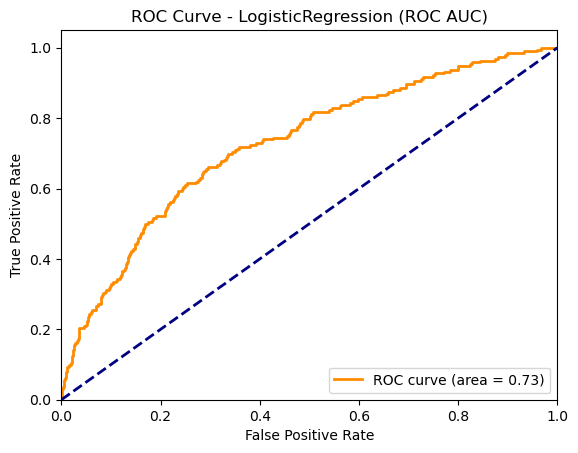

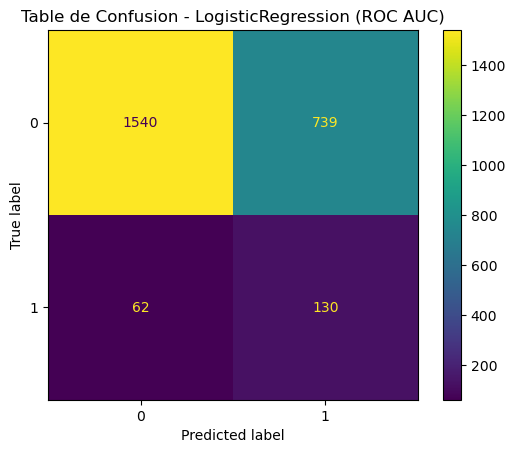

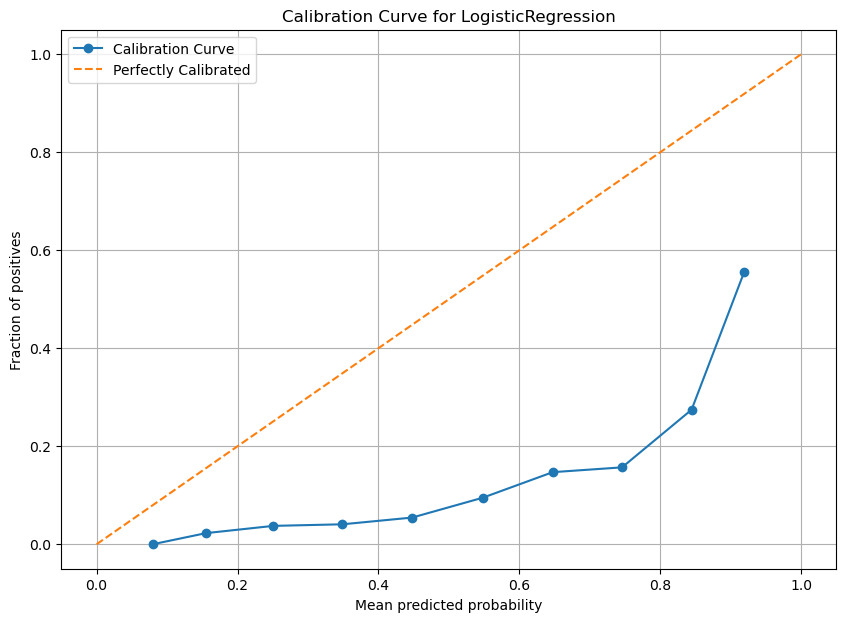

2024/09/29 13:31:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_ROC_AUC at: http://localhost:5000/#/experiments/0/runs/8a281a947a654769823e09bbbbb9e867.
2024/09/29 13:31:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Temps d'exécution total: 4.91 secondes


In [7]:
# Début du chronométrage
start_time = time.time()

# Define the model path
model_path = "mlflow_model"

# Check if the path exists and is not empty
if os.path.exists(model_path) and os.listdir(model_path):
    shutil.rmtree(model_path)
os.makedirs(model_path, exist_ok=True)

# Connexion au serveur MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient("http://127.0.0.1:5000")

# Tentative de connexion au serveur
try:
    experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
    print("Connexion au serveur MLflow. Expériences détectées:")
    for exp in experiments:
        print(f"Expérience ID: {exp.experiment_id}, Nom: {exp.name}")
except Exception as e:
    print("Échec de la connexion au serveur MLflow:", e)
    

# Création du pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns)
    ],
    remainder='passthrough'
)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(sample_predictors, sample_target, test_size=0.2, random_state=42)

# Application de SMOTE pour gérer les données déséquilibrées
smote = SMOTE(random_state=42)

# Signature pour MLFlow
signature = infer_signature(X_train, y_train)

# Définition des modèles et des grilles de paramètres, avec remplacement par GradientBoostingClassifier
models = [
    #("GradientBoosting", GradientBoostingClassifier(), {
     #   'model__n_estimators': randint(50, 500),
      #  'model__max_depth': randint(2, 10),
       # 'model__learning_rate': uniform(0.01, 0.3),
        #'model__subsample': uniform(0.6, 1),
        #'model__min_samples_split': randint(6, 10),
        #'model__min_samples_leaf': randint(3, 10)
    #}),
    ("LogisticRegression", LogisticRegression(solver='liblinear', max_iter=500), {
        'model__C': uniform(0.01,2),
        'model__penalty': ['l1', 'l2']
    })#,
    #("NeuralNetwork", MLPClassifier(max_iter=500), {
     #   'model__hidden_layer_sizes': [(10,),(20,),(50,)],
      #  'model__activation': ['tanh', 'relu'],
       # 'model__solver': ['sgd', 'adam'],
        #'model__alpha': uniform(0.0001, 0.05),
        #'model__learning_rate': ['constant','adaptive']
    #})
]
#LGBM
#
# DataFrame pour stocker les performances des modèles et autres informations
performance_df = pd.DataFrame(columns=[
    'Model', 'Train Accuracy', 'Train F1 Score', 'Train ROC AUC', 'Train F10 Score',
    'Test Accuracy', 'Test F1 Score', 'Test ROC AUC', 'Test F10 Score', 
    'Best Params', 'CV Train Mean Score', 'CV Train Std Dev', 'CV Test Mean Score', 'CV Test Std Dev'
])

# Boucle pour entraîner et suivre chaque modèle
for model_name, model, param_dist in models:
    print(f"Entraînement pour le modèle: {model_name}")

    # Construction du pipeline avec SMOTE
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),  # Prétraitement des données
        ('smote', smote),  # Ajout de SMOTE pour rééquilibrer les classes
        ('model', model)  # Modèle à entraîner
    ])

    # Définition des scoreurs
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)# a changer
    
    # ----------- Grid Search avec ROC AUC -----------
    print(f"Grid Search CV pour {model_name} avec ROC AUC")
    with mlflow.start_run(run_name=f"{model_name}_ROC_AUC"):
        random_search_roc = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_dist,
            n_iter=10,
            #scoring=roc_auc_scorer,
            scoring='roc_auc',  # Optimiser ROC AUC
            cv=5,
            verbose=2,
            random_state=42,
            n_jobs=-1,
            return_train_score=True
        )

        random_search_roc.fit(X_train, y_train)
        best_params_roc = random_search_roc.best_params_
        print("Best params roc")
        print(best_params_roc)
        
        # Récupération la moyenne et l'écart-type des scores de validation croisée pour ROC AUC
        cv_train_mean_score_roc = random_search_roc.cv_results_['mean_train_score'].mean()
        cv_train_std_score_roc = random_search_roc.cv_results_['std_train_score'].mean()
        cv_test_mean_score_roc = random_search_roc.cv_results_['mean_test_score'].mean()
        cv_test_std_score_roc = random_search_roc.cv_results_['std_test_score'].mean()


        # Meilleur modèle pour ROC AUC
        best_model_roc = random_search_roc.best_estimator_
        y_pred_train_roc = best_model_roc.predict(X_train)
        y_pred_prob_train_roc = best_model_roc.predict_proba(X_train)[:, 1]
        y_pred_roc = best_model_roc.predict(X_test)
        y_pred_prob_roc = best_model_roc.predict_proba(X_test)[:, 1]

        # Calcul des métriques
        train_roc_auc = roc_auc_score(y_train, y_pred_prob_train_roc)
        test_roc_auc = roc_auc_score(y_test, y_pred_prob_roc)
        
        # Log dans MLFlow pour best params
        mlflow.log_params(best_params_roc, f"{model_name}_ROC_AUC_model")
        # Log dans MLFlow pour ROC AUC
        mlflow.log_metrics({
            "train_cv_mean":cv_train_mean_score_roc,
            "test_cv_mean":cv_test_mean_score_roc,
            "train_roc_auc": train_roc_auc,
            "test_roc_auc": test_roc_auc
        })
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(best_model_roc, f"{model_name}_ROC_AUC_model")

        
        draw_roc_curv_roc_auc(ytest = y_test, ypredprobroc= y_pred_prob_roc, model_name=model_name)
        mlflow.log_artifact(f"roc_curve_{model_name}_ROC_AUC.png")

        # ----------- Ajout de la Table de Confusion pour ROC AUC ----------- #
        # Calcul et affichage de la matrice de confusion pour ROC AUC
        plot_confusion_matrix_auc_roc(ytest = y_test, ypredprobroc = y_pred_roc, model_name = model_name)
        mlflow.log_artifact(f"confusion_matrix_{model_name}_ROC_AUC.png")
        
        plot_calibration_curve(y_test, y_pred_prob_roc, model_name)

# Fin du chronométrage et calcul du temps écoulé
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps d'exécution total: {elapsed_time:.2f} secondes")

mlflow.end_run()

In [8]:
import mlflow
mlflow.end_run()

In [9]:
mlflow.end_run()